# Movie release delays between US and Japan

Being a big movie buff and living in Japan for almost a decade, I've always wondered--how long does it really take for a movie to make it over the Pacific? I decided to scrape Wikipedia and take a look at all of the Hollywood films released since 1990 and seeing how the release date delay has changed over time.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_movies = pd.read_csv('movies_1990-2019.csv', index_col=0)
df_movies.head()

,year,quarter,title,studio,castcrew,link_en,dates_raw,date_us,date_jp,delay
Unnamed: 0,,,,,,,,,,
0,1990,Q1,Downtown,20th Century Fox,Richard Benjamin (director); Nat Mauldin (scre...,Downtown_(film),{{flagicon|USA}} {{flagicon|CAN}} 1990年1月12日<b...,1990-01-12,NaN,NaN
1,1990,Q1,Internal Affairs,Paramount Pictures,Mike Figgis (director); Henry Bean (screenplay...,Internal_Affairs_(film),{{flagicon|USA}} 1990年1月12日<br /> {{flagicon|J...,1990-01-12,1990-06-29,168.0
2,1990,Q1,Leatherface: The Texas Chainsaw Massacre III,New Line Cinema,Jeff Burr (director); David J. Schow (screenpl...,Leatherface:_The_Texas_Chainsaw_Massacre_III,{{flagicon|USA}} 1990年1月12日<br /> {{flagicon|J...,1990-01-12,1991-10-12,638.0
3,1990,Q1,The Plot Against Harry,New Yorker Films,Michael Roemer (director/screenplay); Martin P...,The_Plot_Against_Harry,no_ja,NaN,NaN,NaN
4,1990,Q1,Ski Patrol,Epic Productions,Richard Correll (director); Steven Long Mitche...,Ski_Patrol_(1990_film),no_ja,NaN,NaN,NaN


I collected this data by scraping Wikipedia entries for Hollywood films released from 1990 to 2019, gathering the English page URL for each film, and then navigating to the Japanese language page (where available) to get the release dates. (see scrape.py for the crawling script)

After quite a bit of cleanup (one of the dates on Wikipedia was 1995-02-30!), I converted the dates to a usable data format and just subtracted the JP date from the US date to get the delay.
 
First let's just take a look at the general trend over the years.

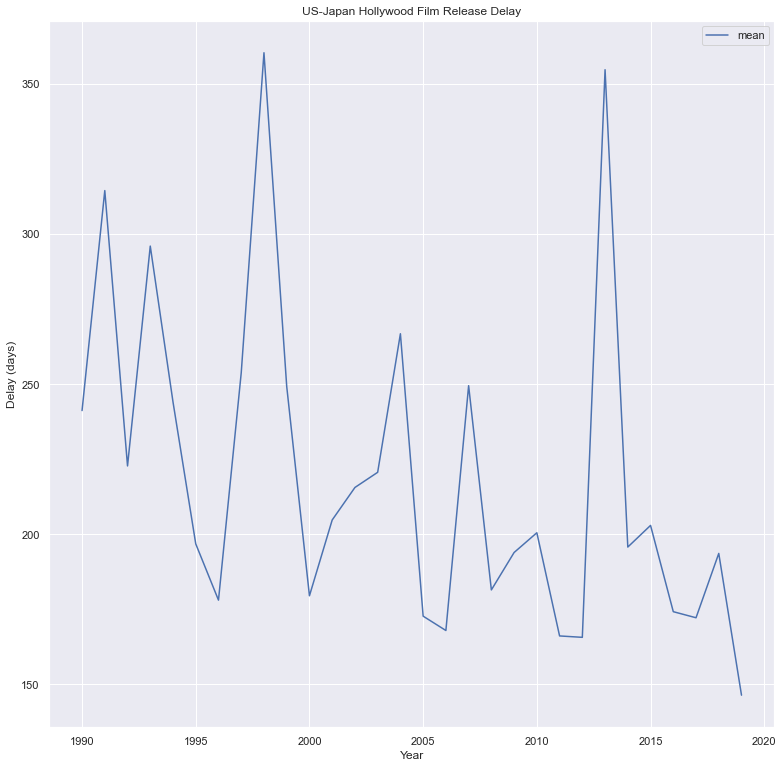

In [2]:
df_year = df_movies.groupby('year')['delay'].agg(['mean'])

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(13,13))
ax.set(title='US-Japan Hollywood Film Release Delay', xlabel='Year', ylabel='Delay (days)')
ax2 = sns.lineplot(data=df_year)

Interesting! Looks like in general the release delay has gotten shorter over time.

Movie studios (and the yearly Wikipedia pages) prefer to look at the quarterly data though, so let's take a look at that.

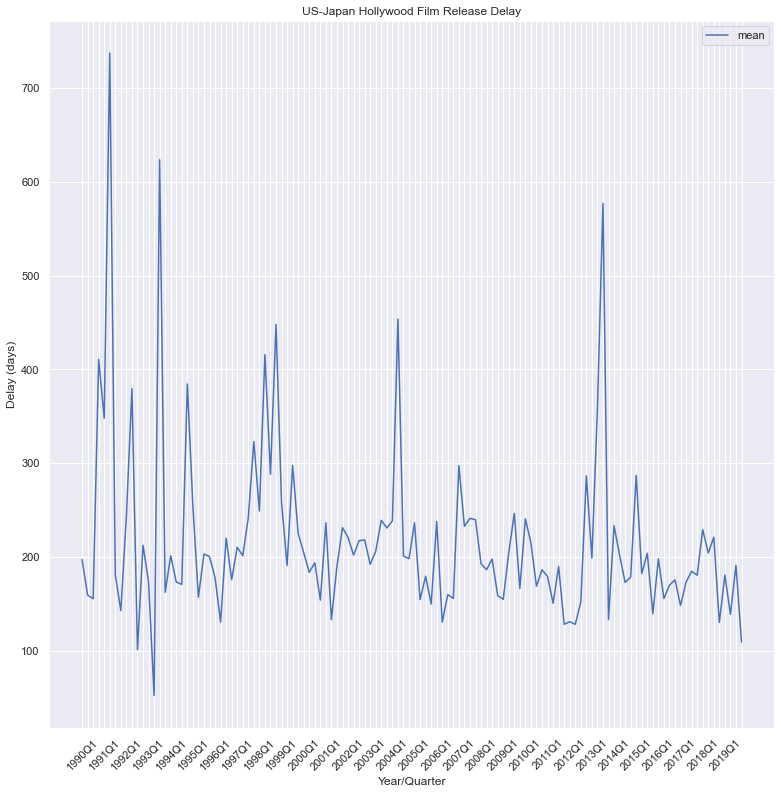

In [3]:
df_movies['yrq'] = df_movies['year'].apply(lambda x: str(x)) + df_movies['quarter']
df_yrq = df_movies.groupby('yrq')['delay'].agg(['mean'])


sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(13,13))
ax = sns.lineplot(data=df_yrq)
ax.set(title='US-Japan Hollywood Film Release Delay', xlabel='Year/Quarter', ylabel='Delay (days)')
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 4 != 0:
        label.set_visible(False)
    else:
        label.set_rotation(45)

In [5]:
yrq_info = df_movies.groupby('yrq')['delay'].agg(['mean','min','max','median','count'])
yrq_info

,mean,min,max,median,count
yrq,,,,,
1990Q1,197.142857,8.0,638.0,189.5,14
1990Q2,159.411765,2.0,470.0,133.0,17
1990Q3,155.346154,-91.0,322.0,158.5,26
1990Q4,410.600000,21.0,5427.0,151.0,25
1991Q1,348.000000,70.0,785.0,309.0,15
...,...,...,...,...,...
2018Q4,130.222222,-168.0,686.0,89.0,36
2019Q1,180.611111,0.0,525.0,148.0,18
2019Q2,138.920000,-188.0,525.0,84.0,25


Much more detailed now, but looking at the new chart and the aggregate statistics, it looks like there may be a few outliers still skewing the data.
For example, there's a movie in Q4 1990 with a release delay of 5427 days--almost 15 whole years!

I'll remove these outliers by tweaking the numbers a bit.
* For one, if a Japanese movie gets released before it's out in Hollywood, we don't need a negative delay value. Let's set these equal to zero.
* Also, let's get rid of the upper outliers by saying anything over 1 year should just count as 1 year.

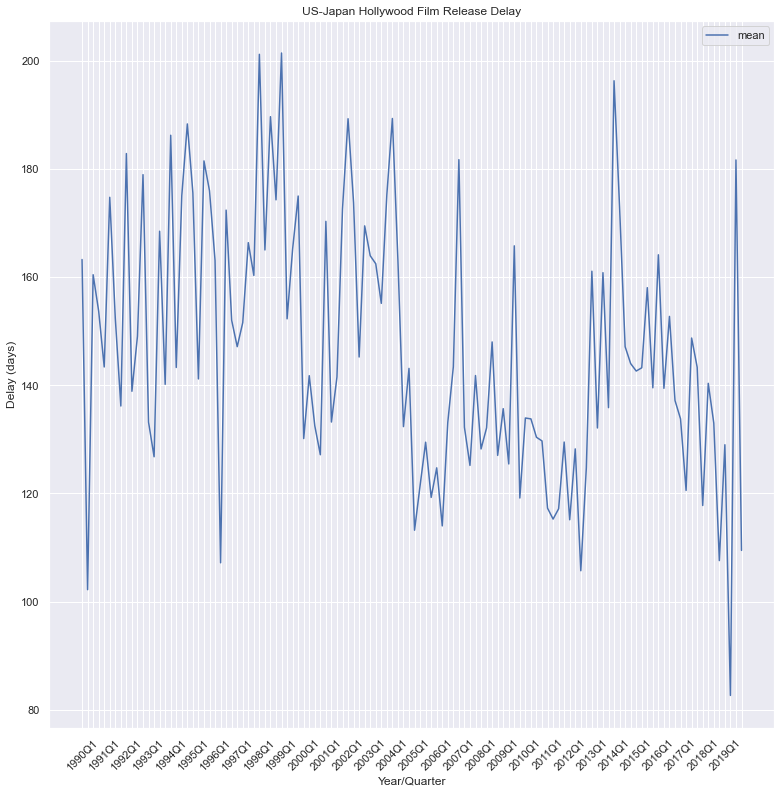

In [6]:
df_movies['delay'] = df_movies['delay'].apply(lambda x: 0 if x < 0 else x)
df_movies['delay'] = df_movies['delay'].apply(lambda x: None if x > 365 else x)
df_yrq = df_movies.groupby('yrq')['delay'].agg(['mean'])

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(13,13))
ax = sns.lineplot(data=df_yrq)
ax.set(title='US-Japan Hollywood Film Release Delay', xlabel='Year/Quarter', ylabel='Delay (days)')
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 4 != 0:
        label.set_visible(False)
    else:
        label.set_rotation(45)

Without the outliers, it still looks like a general downward trend, with release dates getting closer over the years.

It also kind of looks like there are some cyclical dips going on in the data. Could there be one quarter that has shorter release delays than the others? Let's take a look.

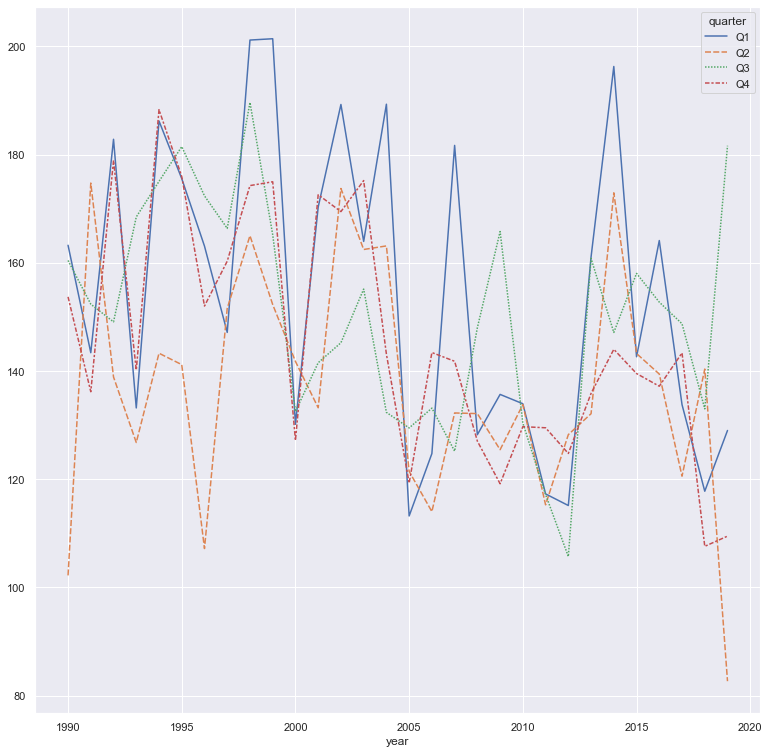

In [7]:
qtr_mean = df_movies.groupby(['year', 'quarter'])['delay'].agg(['mean']).unstack()

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(13,13))
ax = sns.lineplot(data=qtr_mean['mean'])

While it's not a perfectly consistent trend, it certainly looks like Q2 tends to have closer JP releases than other quarters. Interesting! This may have something to do with the fact that big films with high expectations tend to be released in the May-June window, which falls in Q2.


### "Same day" releases

Now let's take a quick look at what I really care about as a moviegoer--how many films per year can I see in Japan on the same day as my friends in the US?
I'll be a bit lenient and extend the definition of "same day" to "within one week," since perfectly synced global releases are usually reserved for only the biggest of blockbusters.

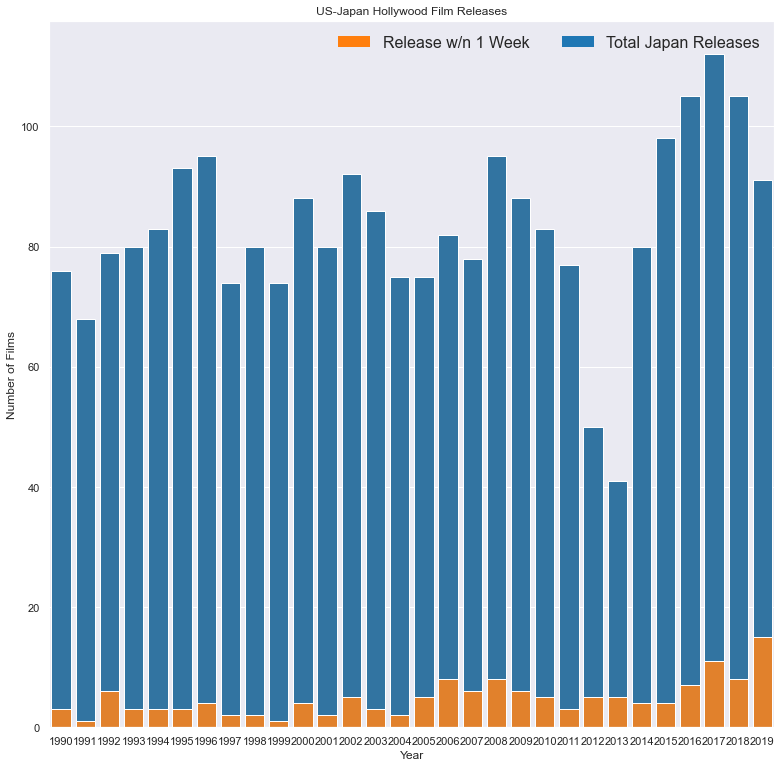

In [31]:
df_movies['oneweek'] = df_movies['delay'].apply(lambda x: 1 if x <= 7 else None)
total_jp = df_movies.groupby('year')['delay'].agg(['count']).reset_index()
oneweeks = df_movies.groupby('year')['oneweek'].agg(['count']).reset_index()

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(13,13))
sns.barplot(data=total_jp, x='year', y='count', ci=None, color='tab:blue')
ax = sns.barplot(data=oneweeks, x='year', y='count', ci=None, color='tab:orange')
ax.set(title='US-Japan Hollywood Film Releases', xlabel='Year', ylabel='Number of Films')

topbar = plt.Rectangle((0,0),1,1,fc="tab:blue", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='tab:orange',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Release w/n 1 Week', 'Total Japan Releases'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

Not a huge percentage at all, but the share has increased over the last decade, and especially since 2016.

Is this really a lot though? Up till now we've only looked at the films that actually got Japanese releases. Let's put things back into perspective by seeing how many films were left stateside over time.

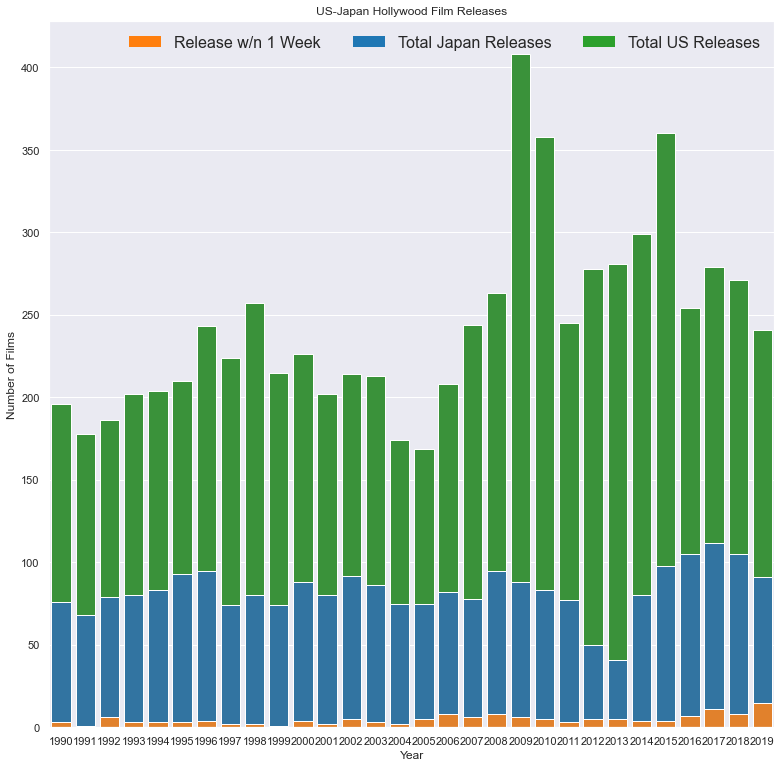

In [32]:
df_movies['oneweek'] = df_movies['delay'].apply(lambda x: 1 if x <= 7 else None)
total_jp = df_movies.groupby('year')['delay'].agg(['count']).reset_index()
oneweeks = df_movies.groupby('year')['oneweek'].agg(['count']).reset_index()
total = df_movies.groupby('year')['title'].agg(['count']).reset_index()

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(13,13))
sns.barplot(data=total, x='year', y='count', ci=None, color='tab:green')
ax = sns.barplot(data=total_jp, x='year', y='count', ci=None, color='tab:blue')
ax = sns.barplot(data=oneweeks, x='year', y='count', ci=None, color='tab:orange')
ax.set(title='US-Japan Hollywood Film Releases', xlabel='Year', ylabel='Number of Films')

fullbar = plt.Rectangle((0,0),1,1,fc="tab:green", edgecolor = 'none')
topbar = plt.Rectangle((0,0),1,1,fc="tab:blue", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='tab:orange',  edgecolor = 'none')
l = plt.legend([bottombar, topbar, fullbar], ['Release w/n 1 Week', 'Total Japan Releases', 'Total US Releases'], loc=1, ncol = 3, prop={'size':16})
l.draw_frame(False)

That certainly puts it into perspective! Less than half of all Hollywood films make it to Japan each year. And like we saw before, only a fraction of them are released within one week of the US release date.


## Next steps
This was a challenging project that has yielded some satisfying results, but it's definitely not perfect. When I come back and spend more time on this, I'd like to clean up/further investigate the following:
* Try to get more complete release date data. Wikipedia was a good starting point, but it's obviously not perfect. For example, I spot checked the Harry Potter films, and none of them have Japanese relase dates in this dataset because the films do not have individual Wikipedia pages in Japanese.
* See if there is a correlation between release delay and IMDB rating, genre, budget, film studio, etc. I'm sure there are many factors that affect the date, but which ones have the biggest pull?
* There is a conspicuous drop in Japanese releases in 2012 and 2013, but this doesn't look to be caused by a drop in US releases. What could be the cause? (Hypothesis: Coudl there have been a lot of American romcoms that year, which usually don't get Japanese releases?)